In [61]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Process Data
External Datasets:
* fred_real_gdp.csv (GDP Growth): https://fred.stlouisfed.org/series/GDPC1
* wgc_gold_prices (Gold Prices): https://www.gold.org/goldhub/data/gold-prices
* fred_sp500 (S&P 500 Prices): https://fred.stlouisfed.org/series/SP500 

In [62]:
# Load data
macro = pd.read_excel('Files/Data_180724.xlsx', sheet_name='Macro')
us_bonds = pd.read_excel('Files/Data_180724.xlsx', sheet_name='Yield')
prices = pd.read_excel('Files/Data_180724.xlsx', sheet_name='Prices')
fred_real_gdp = pd.read_csv('Files/fred_real_gdp.csv')
wgc_gold_prices = pd.read_csv('Files/wgc_gold_prices.csv')
fred_sp500 = pd.read_csv('Files/fred_sp500.csv')

In [63]:
# Check data columns and data type
print(macro.dtypes)
print(us_bonds.dtypes)
print(prices.dtypes)
print(fred_real_gdp.dtypes)
print(wgc_gold_prices.dtypes)
print(fred_sp500.dtypes)

Date       datetime64[ns]
GDP YOY           float64
CPI YOY           float64
dtype: object
Date             datetime64[ns]
US 10YR Bonds           float64
dtype: object
Date                   datetime64[ns]
S&P 500                       float64
Gold                          float64
USD Index Spot Rate           float64
dtype: object
DATE      object
GDPC1    float64
dtype: object
Date     object
Gold    float64
dtype: object
DATE           object
SP500         float64
Unnamed: 2    float64
Unnamed: 3    float64
dtype: object


In [64]:
# Convert all date columns to datetime
prices['Date'] = prices['Date'].dt.date
macro['Date'] = macro['Date'].dt.date
us_bonds['Date'] = us_bonds['Date'].dt.date
wgc_gold_prices['Date'] = pd.to_datetime(wgc_gold_prices['Date'], format="%d/%m/%Y").dt.date
fred_sp500['DATE'] = pd.to_datetime(fred_sp500['DATE'], format="%d/%m/%Y").dt.date

#### Check for missing data

In [65]:
# Check Macro Sheet
macro_gdp_empty = macro.iloc[0::3]
print(macro_gdp_empty.iloc[:, 1].isna().sum())

macro_cpi_empty = macro.iloc[:, 2]
print(macro_cpi_empty.isna().sum())

1
0


In [66]:
empty_gdp = macro_gdp_empty[macro_gdp_empty.iloc[:, 1].isna()]
print(empty_gdp)

           Date  GDP YOY  CPI YOY
642  2024-06-30      NaN      3.0


In [67]:
# Check US Bonds Yield Sheet
us_bonds.isna().sum()

Date             0
US 10YR Bonds    0
dtype: int64

In [68]:
# Check Prices Sheet
prices.isna().sum()

Date                      0
S&P 500                 368
Gold                   1107
USD Index Spot Rate     175
dtype: int64

In [69]:
empty_prices = prices[prices.isna().any(axis=1)]
empty_prices

,Date,S&P 500,Gold,USD Index Spot Rate
1,1971-01-04,91.15,NaN,120.530
2,1971-01-05,91.80,NaN,120.520
3,1971-01-06,92.35,NaN,120.490
4,1971-01-07,92.38,NaN,120.550
5,1971-01-08,92.19,NaN,120.530
...,...,...,...,...
13763,2024-02-19,NaN,2017.21,104.291
13792,2024-03-29,NaN,NaN,104.487
13833,2024-05-27,NaN,2350.97,104.595
13850,2024-06-19,NaN,2328.16,105.254


#### Fill in Missing Values

In [70]:
fred_real_gdp['GDP_YoY'] = fred_real_gdp['GDPC1'].pct_change(periods=4) * 100

# Fill in missing value for Macro Sheet
macro.iloc[642, 1] = fred_real_gdp.iloc[-1, 2]

macro_gdp_empty = macro.iloc[0::3]
print(macro_gdp_empty.iloc[:, 1].isna().sum())

macro_cpi_empty = macro.iloc[:, 2]
print(macro_cpi_empty.isna().sum())

0
0


In [71]:
# Convert dateframe to only show quarterly data
macro.loc[~macro['Date'].apply(lambda x: x.month).isin([3, 6, 9, 12]), 'CPI YOY'] = np.nan
macro.bfill(inplace=True)
macro

,Date,GDP YOY,CPI YOY
0,1970-12-31,-0.200000,5.6
1,1971-01-31,2.700000,4.7
2,1971-02-28,2.700000,4.7
3,1971-03-31,2.700000,4.7
4,1971-04-30,3.100000,4.6
...,...,...,...
638,2024-02-29,2.900000,3.5
639,2024-03-31,2.900000,3.5
640,2024-04-30,2.657112,3.0
641,2024-05-31,2.657112,3.0


In [72]:
fred_sp500.rename(columns={'DATE': 'Date', 'SP500': 'S&P 500'}, inplace=True)  

# Merge prices with fred_sp500 and wgc_gold_prices
prices = prices.merge(fred_sp500[['Date', 'S&P 500']], on='Date', how='left', suffixes=('', '_new'))
prices = prices.merge(wgc_gold_prices[['Date', 'Gold']], on='Date', how='left', suffixes=('', '_new'))

# Fill missing values 
prices['S&P 500'] = prices['S&P 500'].fillna(prices['S&P 500_new'])
prices['Gold'] = prices['Gold'].fillna(prices['Gold_new'])

# Drop the extra columns used for filling
prices.drop(columns=['S&P 500_new', 'Gold_new'], inplace=True)

print(prices.isna().sum())

Date                     0
S&P 500                368
Gold                   990
USD Index Spot Rate    175
dtype: int64


In [73]:
# Forward fill remaining missing values
prices.ffill(inplace=True)

print(prices.isna().sum())

Date                   0
S&P 500                0
Gold                   0
USD Index Spot Rate    0
dtype: int64


## Optimization
Assumptions:
* Optimization Goal: Maximise Sharpe and Beat Market Returns
* Risk-Free Rate is 0
* Range of Possible Hedge Positions for Gold and Bonds: -1 to 1
* Threshold for determining gdp (rising/falling) is 2
* Threshold for determining cpi (rising/falling) is 2
* Modified Duration of a 10-Year Bond is 8

Economic Regime
* Goldilocks - Rising GDP and Falling Inflation
* Slow Growth - Slowing GDP and Falling Inflation
* Stagflation - Slowing GDP and Rising Inflation
* Heating Up - Rising GDP and Rising Inflation


In [74]:
# Define economic regimes
def assign_economic_regime(row):
    if row['GDP YOY'] <= 2 and row['CPI YOY'] > 2:
        return 'Stagflation'
    elif row['GDP YOY'] > 2 and row['CPI YOY'] > 2:
        return 'Heating Up'
    elif row['GDP YOY'] <= 2 and row['CPI YOY'] <= 2:
        return 'Slow Growth'
    elif row['GDP YOY'] > 2 and row['CPI YOY'] <= 2:
        return 'Goldilocks'
    
macro['Economic Regime'] = macro.apply(assign_economic_regime, axis=1)

In [75]:
macro['Year_Month'] = macro['Date'].apply(lambda x: f"{x.year}-{x.month}")
prices['Year_Month'] = prices['Date'].apply(lambda x: f"{x.year}-{x.month}")

# Combine all dataframes
combined_df = prices.merge(macro, on='Year_Month', how='inner')
combined_df = combined_df.merge(us_bonds, left_on='Date_x', right_on='Date', how='inner')

# Filter for Essential Columns for Optimization
combined_df = combined_df[['Date', 'S&P 500', 'Gold', 'US 10YR Bonds', 'Economic Regime']]

print(combined_df[combined_df['Economic Regime'] == 'Stagflation'].shape)
print(combined_df[combined_df['Economic Regime'] == 'Heating Up'].shape)
print(combined_df[combined_df['Economic Regime'] == 'Goldilocks'].shape)
print(combined_df[combined_df['Economic Regime'] == 'Slow Growth'].shape)


(2927, 5)
(7572, 5)
(1955, 5)
(1237, 5)


#### Calculate Returns

In [76]:
modified_duration = 8 # Assumption

combined_df['S&P 500 Return'] = combined_df['S&P 500'].pct_change()
combined_df['Gold Return'] = combined_df['Gold'].pct_change()
combined_df['US 10YR Bonds Return'] = -modified_duration * combined_df['US 10YR Bonds'].pct_change()
combined_df.dropna(inplace=True)
combined_df

,Date,S&P 500,Gold,US 10YR Bonds,Economic Regime,S&P 500 Return,Gold Return,US 10YR Bonds Return
1,1971-01-04,91.15,37.44,6.4620,Heating Up,-0.010852,0.000000,0.049216
2,1971-01-05,91.80,37.44,6.4720,Heating Up,0.007131,0.000000,-0.012380
3,1971-01-06,92.35,37.44,6.4720,Heating Up,0.005991,0.000000,-0.000000
4,1971-01-07,92.38,37.44,6.4520,Heating Up,0.000325,0.000000,0.024722
5,1971-01-08,92.19,37.44,6.4420,Heating Up,-0.002057,0.000000,0.012399
...,...,...,...,...,...,...,...,...
13686,2024-06-24,5447.87,2334.65,4.2321,Heating Up,-0.003065,0.005457,0.043803
13687,2024-06-25,5469.30,2319.62,4.2476,Heating Up,0.003934,-0.006438,-0.029300
13688,2024-06-26,5477.90,2298.23,4.3294,Heating Up,0.001572,-0.009221,-0.154063
13689,2024-06-27,5482.87,2327.73,4.2864,Heating Up,0.000907,0.012836,0.079457


#### Plot S&P500 Returns in Each Regime

Conclusion: Use mean returns for Stagflation, Goldilocks and Slow Growth regime, use median for Heating Up regime.


Skewness of S&P 500 Returns (Heating Up): -1.900125398893881
Skewness of S&P 500 Returns (Stagflation): -0.056968259343435995
Skewness of S&P 500 Returns (Goldilocks): -0.21577856277007415
Skewness of S&P 500 Returns (Slow Growth): -0.09413766892657177


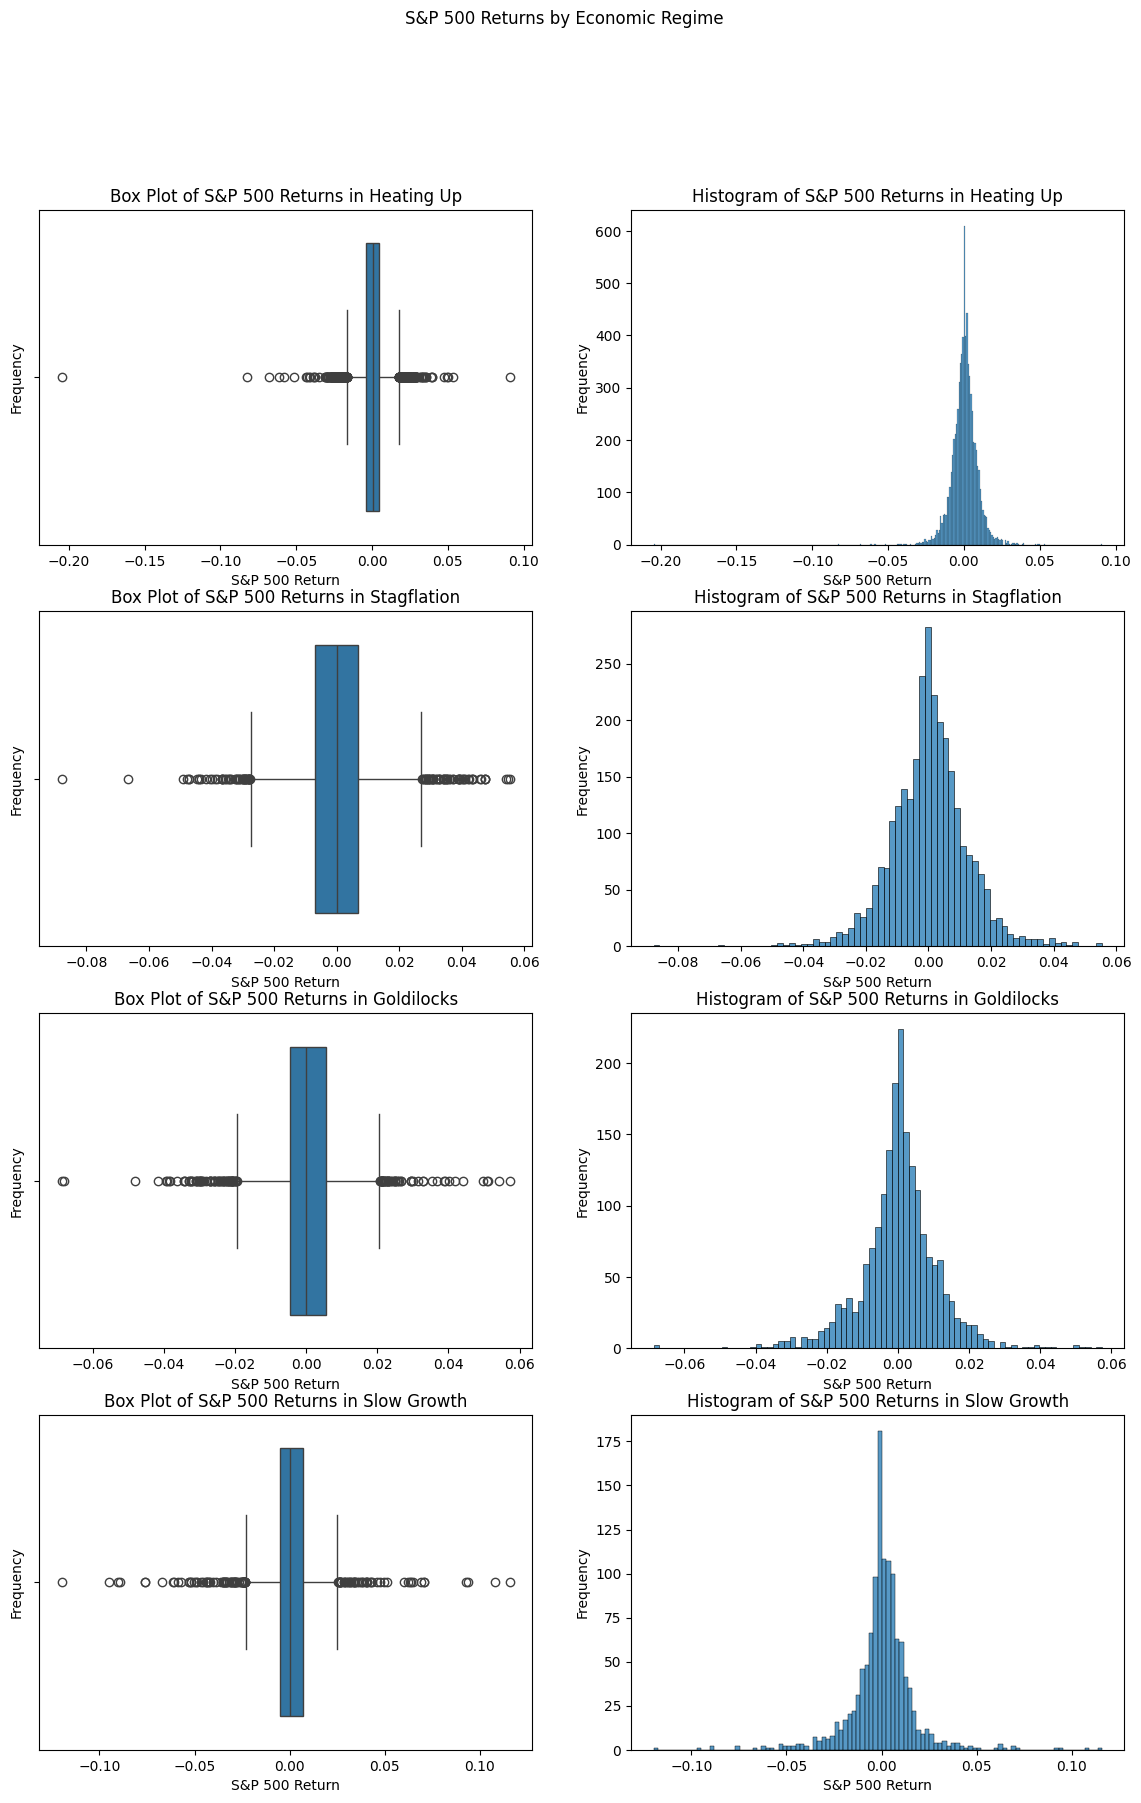

In [77]:
regimes = combined_df['Economic Regime'].unique()

fig, axes = plt.subplots(len(regimes), 2, figsize=(14, 5 * len(regimes)))
fig.suptitle('S&P 500 Returns by Economic Regime')

for i, regime in enumerate(regimes):
    # Filter data by specific regime
    regime_data = combined_df[combined_df['Economic Regime'] == regime]
    
    # Boxplott
    sns.boxplot(x=regime_data['S&P 500 Return'], ax=axes[i, 0])
    axes[i, 0].set_title(f'Box Plot of S&P 500 Returns in {regime}')
    axes[i, 0].set_xlabel('S&P 500 Return')
    axes[i, 0].set_ylabel('Frequency')
    
    # Histogram 
    sns.histplot(regime_data['S&P 500 Return'], ax=axes[i, 1])
    axes[i, 1].set_title(f'Histogram of S&P 500 Returns in {regime}')
    axes[i, 1].set_xlabel('S&P 500 Return')
    axes[i, 1].set_ylabel('Frequency')

    # Calculate skewness
    skewness = skew(regime_data['S&P 500 Return'])
    print(f"Skewness of S&P 500 Returns ({regime}): {skewness}")

plt.show()

In [78]:
# Objective Function
def calc_neg_sharpe_ratio(weights, returns_df, sp500_returns, risk_free_rate=0):
    portfolio_return = sp500_returns + np.dot(returns_df, weights)
    daily_sharpe_ratio = (portfolio_return.mean() - risk_free_rate) / portfolio_return.std()
    annual_sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)
    return -annual_sharpe_ratio


# Constraint function based on regime
def regime_based_constraint(weights, returns_df, sp500_returns, regime='default'):
    portfolio_return = sp500_returns + np.dot(returns_df, weights)
    
    if regime == 'Heating Up':
        return np.median(portfolio_return) - np.median(sp500_returns)
    else:
        return portfolio_return.mean() - sp500_returns.mean()
    
# Optimization function
def optimize_hedge_weights(returns_df, sp500_returns, risk_free_rate=0, regime='default'):
    objective_func = lambda weights: calc_neg_sharpe_ratio(weights, returns_df, sp500_returns, risk_free_rate=risk_free_rate)
    
    constraints = [
        {'type': 'ineq', 'fun': lambda weights: regime_based_constraint(weights, returns_df, sp500_returns, regime=regime)}
    ]
    
    # Assumption: Allow weights of Gold and Bonds between -1 and 1
    bounds = [(-1, 1), (-1, 1)]
    
    initial_guess = [0.5, 0.5]

    result = minimize(objective_func, initial_guess, bounds=bounds, constraints=constraints)
    if result.success:
        optimized_weights = result.x

        # Calculate optimized sharpe and returns
        portfolio_return = sp500_returns + np.dot(returns_df, optimized_weights)
        daily_sharpe_ratio = (portfolio_return.mean() - risk_free_rate) / portfolio_return.std()
        annual_sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)
        
        print(f"{regime}")
        print("Optimized Weights (Gold, Bonds):", [f"{weight:.3f}" for weight in optimized_weights])
        print("Achieved Annual Sharpe Ratio:", f"{annual_sharpe_ratio:.2f}")
        print("Achieved Average Daily Return:", f"{portfolio_return.mean() * 100:.2f} %")
        print()
        return optimized_weights


In [79]:
# Out-of-Sample (oos) analysis - using optimized weights of one regime in all other regimes
# Print Annual Sharpe Ratio, Average Daily Return
def oos_analysis(weights, risk_free_rate=0, regime=regime):
    oos = combined_df[combined_df['Economic Regime'] != regime]
    oos_returns = oos[['Gold Return', 'US 10YR Bonds Return']].values
    oos_sp500_returns = oos['S&P 500 Return'].values
    oos_portfolio_return = oos_sp500_returns + np.dot(oos_returns, weights)
    oos_daily_sharpe_ratio = (oos_portfolio_return.mean() - risk_free_rate) / oos_portfolio_return.std()
    oos_annual_sharpe_ratio = oos_daily_sharpe_ratio * np.sqrt(252)
    print(f"{regime} - Out-of-Sample Analysis")
    print("Weights (Gold, Bonds):", [f"{weight:.3f}" for weight in weights])
    print("Achieved Annual Sharpe Ratio:", f"{oos_annual_sharpe_ratio:.2f}")
    print("Achieved Average Daily Return:", f"{oos_portfolio_return.mean() * 100:.2f} %")

In [80]:
for regime, group in combined_df.groupby('Economic Regime'):
    returns_df = group[['Gold Return', 'US 10YR Bonds Return']].values
    sp500_returns = group['S&P 500 Return'].values
    # Get optimize weights, print optimized weights, annual sharpe ratio and average daily return
    print("="*50)
    optimized_weights = optimize_hedge_weights(returns_df, sp500_returns, regime=regime)

    # Out-of-Sample (oos) analysis
    oos_analysis(optimized_weights, regime=regime)
    print("="*50)


Goldilocks
Optimized Weights (Gold, Bonds): ['0.371', '0.059']
Achieved Annual Sharpe Ratio: 0.77
Achieved Average Daily Return: 0.06 %

Goldilocks - Out-of-Sample Analysis
Weights (Gold, Bonds): ['0.371', '0.059']
Achieved Annual Sharpe Ratio: 0.47
Achieved Average Daily Return: 0.04 %
Heating Up
Optimized Weights (Gold, Bonds): ['0.672', '-0.050']
Achieved Annual Sharpe Ratio: 1.08
Achieved Average Daily Return: 0.08 %

Heating Up - Out-of-Sample Analysis
Weights (Gold, Bonds): ['0.672', '-0.050']
Achieved Annual Sharpe Ratio: 0.41
Achieved Average Daily Return: 0.05 %
Slow Growth
Optimized Weights (Gold, Bonds): ['1.000', '0.019']
Achieved Annual Sharpe Ratio: 0.58
Achieved Average Daily Return: 0.08 %

Slow Growth - Out-of-Sample Analysis
Weights (Gold, Bonds): ['1.000', '0.019']
Achieved Annual Sharpe Ratio: 0.71
Achieved Average Daily Return: 0.07 %
Stagflation
Optimized Weights (Gold, Bonds): ['1.000', '-0.086']
Achieved Annual Sharpe Ratio: 0.57
Achieved Average Daily Return: 0

## Conclusion

#### Goldilocks
Optimized Weights (Gold, Bonds): ['0.371', '0.059']  
Achieved Annual Sharpe Ratio: 0.77  
Achieved Average Daily Return: 0.06 %  

#### Goldilocks - Out-of-Sample Analysis
Weights (Gold, Bonds): ['0.371', '0.059']  
Achieved Annual Sharpe Ratio: 0.47  
Achieved Average Daily Return: 0.04 %  

#### Heating Up
Optimized Weights (Gold, Bonds): ['0.672', '-0.050']  
Achieved Annual Sharpe Ratio: 1.08  
Achieved Average Daily Return: 0.08 %  

#### Heating Up - Out-of-Sample Analysis
Weights (Gold, Bonds): ['0.672', '-0.050']  
Achieved Annual Sharpe Ratio: 0.41  
Achieved Average Daily Return: 0.05 %  

#### Slow Growth
Optimized Weights (Gold, Bonds): ['1.000', '0.019']  
Achieved Annual Sharpe Ratio: 0.58  
Achieved Average Daily Return: 0.08 %  

#### Slow Growth - Out-of-Sample Analysis
Weights (Gold, Bonds): ['1.000', '0.019']  
Achieved Annual Sharpe Ratio: 0.71  
Achieved Average Daily Return: 0.07 %  

#### Stagflation
Optimized Weights (Gold, Bonds): ['1.000', '-0.086']  
Achieved Annual Sharpe Ratio: 0.57  
Achieved Average Daily Return: 0.09 %  

#### Stagflation - Out-of-Sample Analysis
Weights (Gold, Bonds): ['1.000', '-0.086']  
Achieved Annual Sharpe Ratio: 0.64  
Achieved Average Daily Return: 0.08 %  